Based on:

P. Donizy, M. Krzyzinski et al. Machine learning models demonstrate that clinicopathologic variables are comparable to gene expression prognostic signature in predicting survival in uveal melanoma. 

European Journal of Cancer, 2022.

paper: https://doi.org/10.1016/j.ejca.2022.07.031

code: https://doi.org/10.24433/CO.0762447.v1

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from matplotlib.collections import LineCollection
from sksurv.util import Surv

import src

In [2]:
df_train_raw = pd.read_csv('data/uvealmelanoma_ejc2022_train.csv')
df_valid_raw = pd.read_csv('data/uvealmelanoma_ejc2022_valid.csv')

In [3]:
categorical_variables = ["sex",
                         "stage",
                         "tumor.location",
                         "histologic.subtype",               
                         "scleral.infiltration",
                         "invasion.optic.nerve.head",        
                         "extraocular.growth",
                         "necrosis",                         
                         "lymphovascular.invasion",
                         "pigmentation.clinical",            
                         "tumor.shape",
                         "retinal.detachment",               
                         "glaucoma",
                         "clinical.localization",
                         "TIL.pattern",    
                         "TIL.density",
                         "TIM.pattern",    
                         "TIM.density",
                         "pigment.quantity",            
                         "pigment.quality",
                         "nucleoli.size",
                         "hemorrhage",                       
                         "BAP1.mutation",
                         "ciliary.body.infiltration"]

In [4]:
df_train = df_train_raw.dropna().reset_index(drop=True)
X_train = df_train.drop(["os.status", "os", "pfs.status", "pfs"] + categorical_variables, axis=1)
y_train = Surv().from_dataframe("os.status", "os", df_train)

In [5]:
df_valid = df_valid_raw.dropna().reset_index(drop=True).loc[:, pd.Series(np.intersect1d(df_valid_raw.columns.values, df_train_raw.columns.values))]
X_valid = df_valid.drop(["os.status", "os", "pfs.status", "pfs"] + np.intersect1d(df_valid_raw.columns.values, categorical_variables).tolist(), axis=1)
X_valid = X_valid.loc[:, X_train.columns]
y_valid = Surv().from_dataframe("os.status", "os", df_valid)

In [92]:
X_valid.shape

(77, 9)

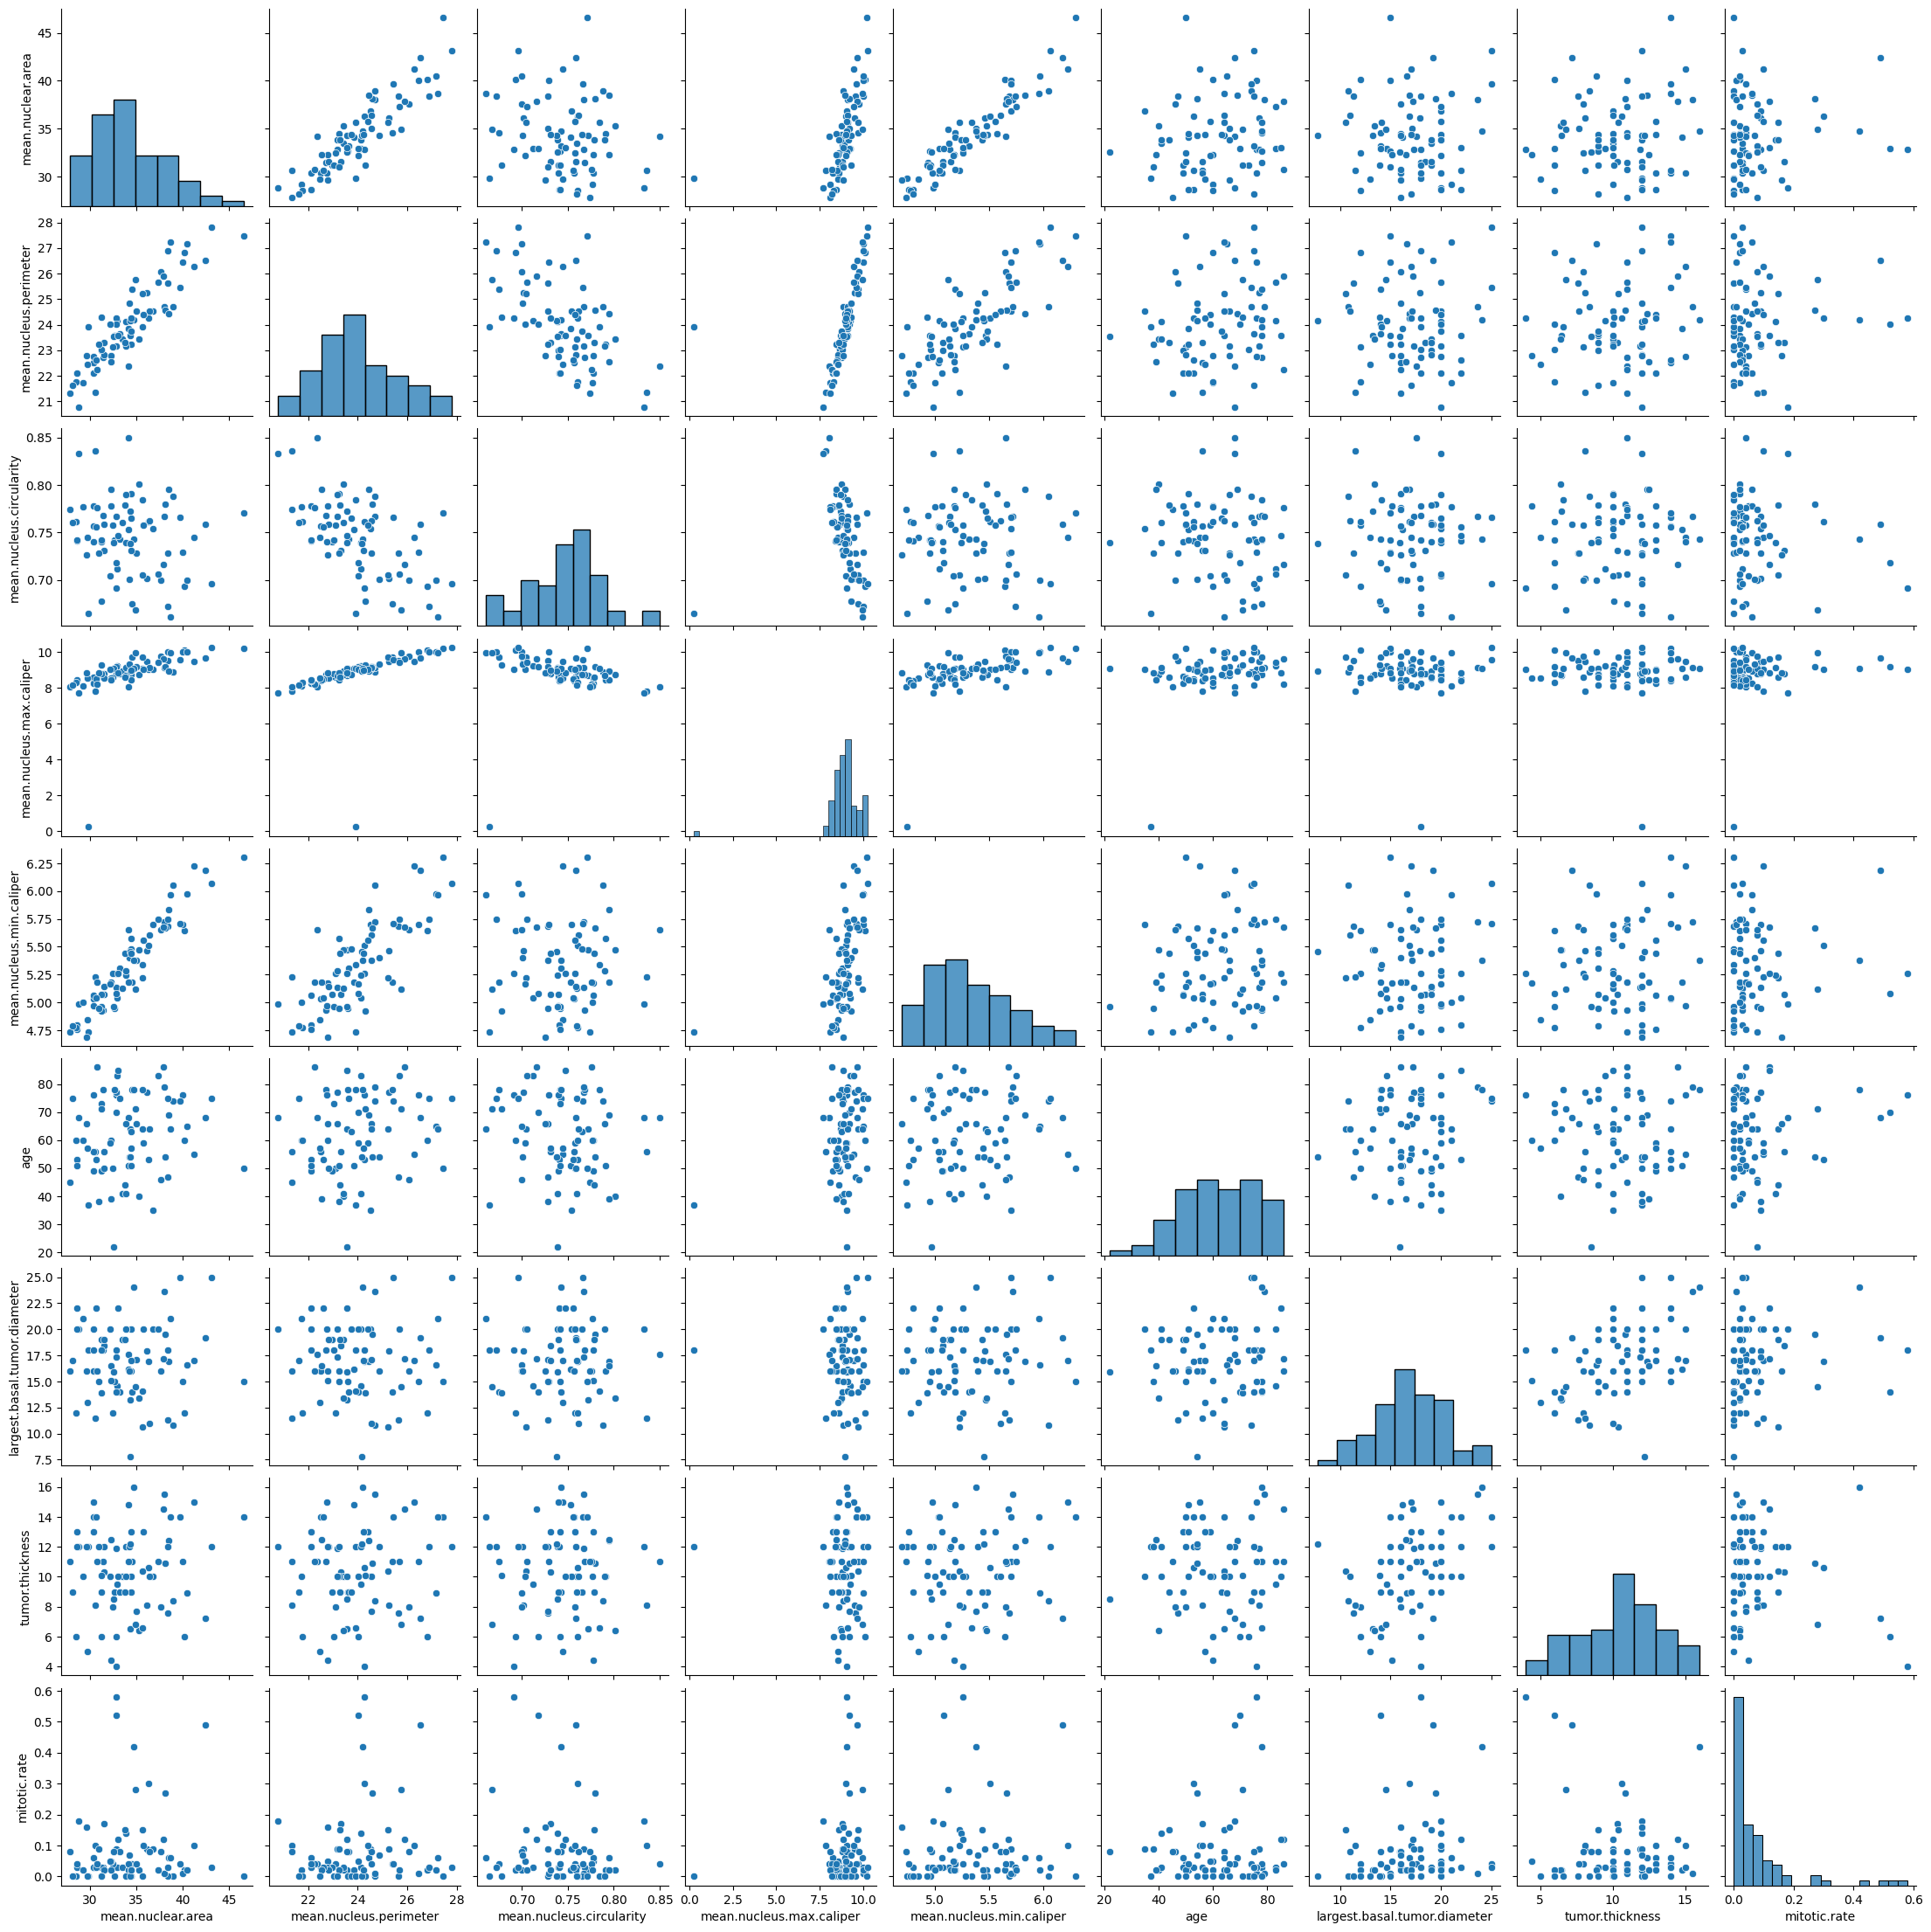

In [66]:
sns.pairplot(X_valid)

In [6]:
# model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=456)
# model = RandomSurvivalForest(n_estimators=100, max_depth=6, random_state=456)
model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=456)

In [7]:
model.fit(X_train.values, y_train)

,loss,'coxph'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,random_state,456


In [8]:
print(f'Train score: {model.score(X_train.values, y_train).item():.03f} | Valid score: {model.score(X_valid.values, y_valid).item():.03f}')

Train score: 0.927 | Valid score: 0.758


In [ ]:
np.random.seed(456)
explanations_order1 = src.survshapiq(
    model, 
    X_train.values, 
    [X_valid.iloc[[i]] for i in range(0, X_valid.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="SV",
    approximator="auto",
    max_order=1
)

In [ ]:
filename = f'results/uvealmelanoma_explanations_order1_gbs_maxdepth4.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order1, f)

In [11]:
filename = f'results/uvealmelanoma_explanations_order1_gbs_maxdepth4.pkl'
with open(filename, 'rb') as f:
    explanations_order1 = pickle.load(f)

In [12]:
timepoints = src.get_evenly_spaced_integers(model.unique_times_, 41)

In [13]:
df_plot1 = pd.concat([explanations_order1[i].assign(time=timepoints, id=i) for i in range(X_valid.shape[0])])
df_plot1 = pd.melt(df_plot1, id_vars=['time', 'id'], var_name="feature")

In [14]:
df_plot1.feature.unique()

array(['mean.nuclear.area', 'mean.nucleus.perimeter',
       'mean.nucleus.circularity', 'mean.nucleus.max.caliper',
       'mean.nucleus.min.caliper', 'age', 'largest.basal.tumor.diameter',
       'tumor.thickness', 'mitotic.rate'], dtype=object)

In [15]:
df_plot1.feature = df_plot1.feature.map({
    'mean.nuclear.area': 'nuclear_area', 
    'mean.nucleus.perimeter': 'nucleus_perimeter',
    'mean.nucleus.circularity': 'nucleus_circularity',
    'mean.nucleus.max.caliper': 'nucleus_max_caliper',
    'mean.nucleus.min.caliper': 'nucleus_min_caliper',
    'age': 'age',
    'largest.basal.tumor.diameter': 'max_tumor_diameter',
    'tumor.thickness': 'tumor_thickness',
    'mitotic.rate': 'mitotic_rate'
})

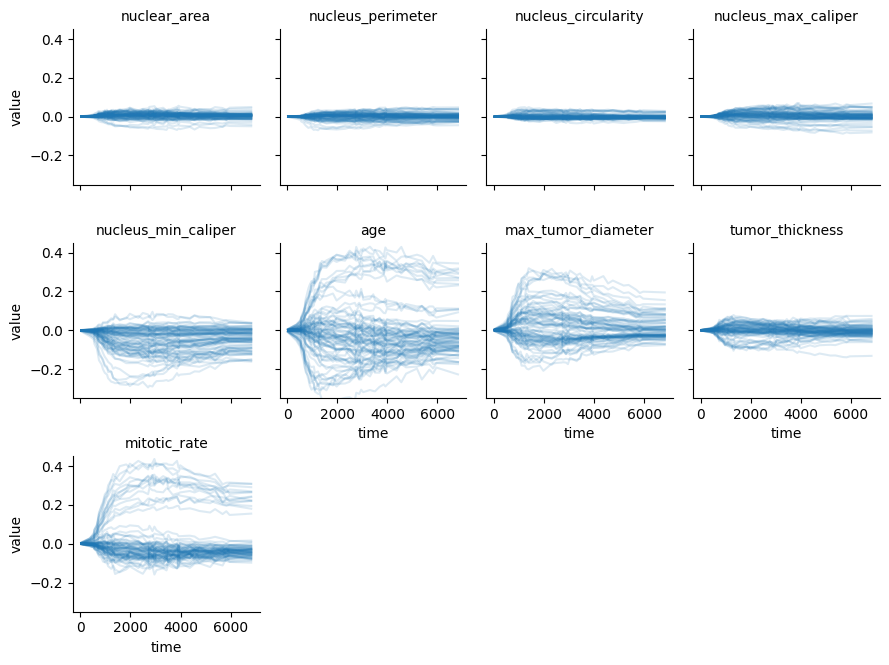

In [ ]:
ax = sns.relplot(
    df_plot1, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2.25,
    aspect=1,
    col_wrap=4
)
ax.set_titles(col_template="{col_name}")
# ax.set(xscale='log')
ax.set(ylim=(-0.35, 0.45))
plt.tight_layout()
plt.savefig(f'results/uvealmelanoma_order1_gbs_maxdepth4.png', bbox_inches="tight")

In [16]:
df_plot1 = df_plot1.assign(color=pd.concat([X_valid.iloc[:, i].repeat(41) for i in range(X_valid.shape[1])]).values)

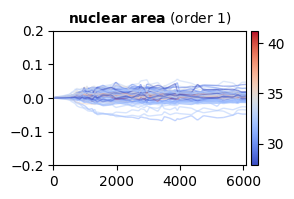

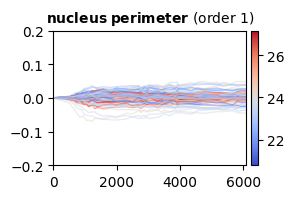

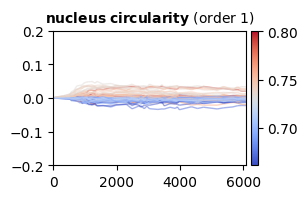

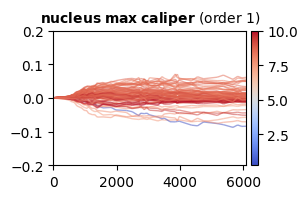

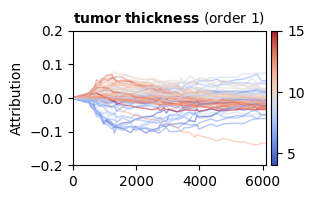

In [81]:
for feature_name in df_plot1.feature.unique():
    ## different ax.set_ylim
    if feature_name in ['age', 'max_tumor_diameter', 'mitotic_rate', 'nucleus_min_caliper']:
        continue 
    # if feature_name not in ['age', 'max_tumor_diameter', 'mitotic_rate', 'nucleus_min_caliper']:
    #     continue 
    temp = df_plot1[df_plot1.feature == feature_name]
    fig, ax = plt.subplots(figsize=(3, 1.75))

    CMAP = "coolwarm"

    for id_val in temp.id.unique():
        line_data = temp[temp.id == id_val].sort_values(by="time")
        x = line_data["time"].values
        y = line_data["value"].values
        c = line_data["color"].values

        # Create line segments with color
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=CMAP, # coolwarm
            norm=plt.Normalize(temp.color.min(), temp.color.max()),
            array=c[:-1],  # color values
            linewidth=1,
            alpha=0.5
        )
        ax.add_collection(lc)

    ax.set_xlim(0, 6100)
    # ax.set_ylim(-0.35, 0.45)
    ax.set_ylim(-0.2, 0.2)
    ax.set_title("$\mathbf{" + str(feature_name).replace("_", "\;") + "}$ (order 1)", fontsize=10)

    if feature_name in ["tumor_thickness", "age"]:
        ax.set_ylabel('Attribution')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
    sm.set_array([])  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    # cbar.set_label("color value")
    # plt.tight_layout()
    plt.savefig(f'results/um_order1_global_{feature_name}.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

### Order 2

In [ ]:
np.random.seed(456)
explanations_order2 = src.survshapiq(
    model, 
    X_train.values, 
    [X_valid.iloc[[i]] for i in range(0, X_valid.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="k-SII",
    approximator="auto",
    max_order=2
)

In [ ]:
filename = f'results/uvealmelanoma_explanations_order2_gbs_maxdepth4.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order2, f)

In [40]:
filename = f'results/uvealmelanoma_explanations_order2_gbs_maxdepth4.pkl'
with open(filename, 'rb') as f:
    explanations_order2 = pickle.load(f)

In [41]:
df_plot2 = pd.concat([explanations_order2[i].assign(time=timepoints, id=i) for i in range(X_valid.shape[0])])
df_plot2 = pd.melt(df_plot2, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])

Misc

In [ ]:
df_plot2.feature = df_plot2.feature.str.replace("*", "\n *")

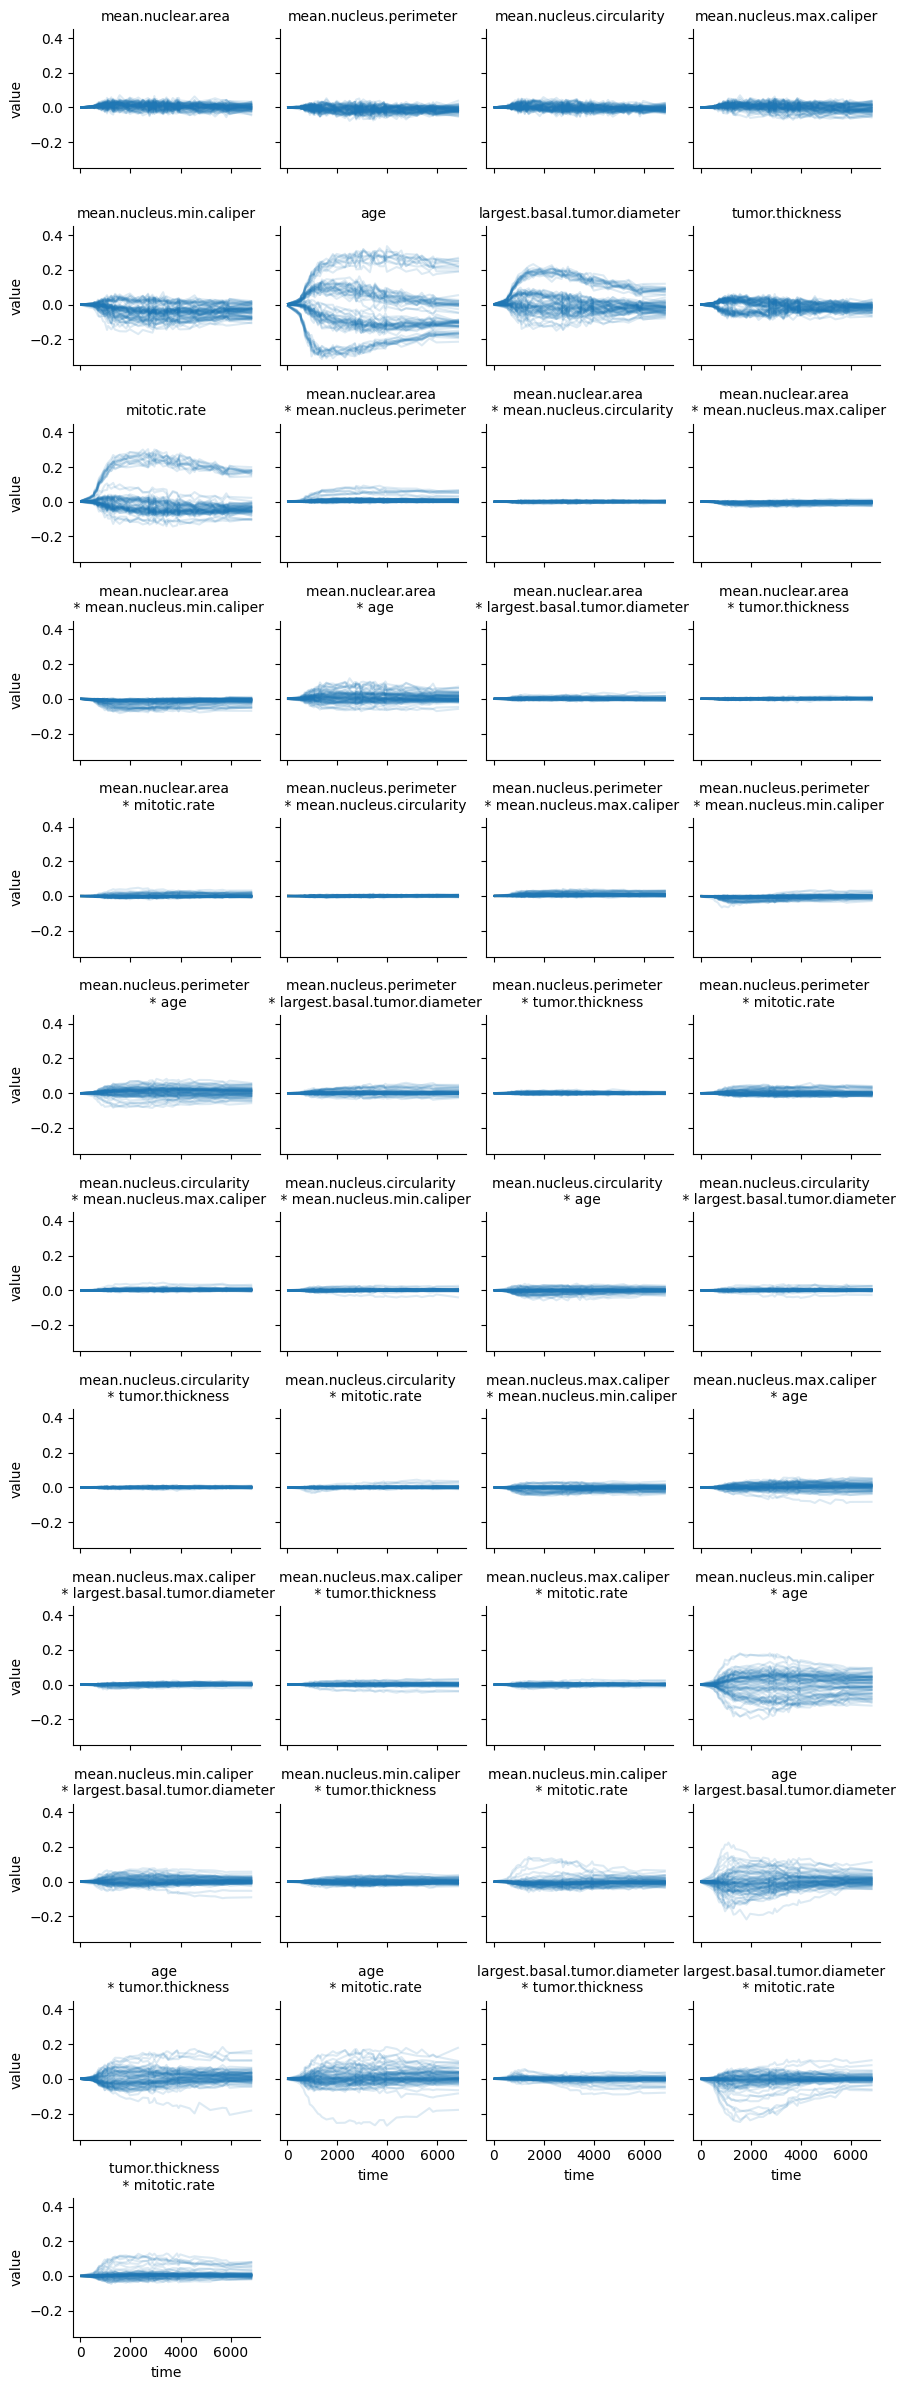

In [ ]:
ax = sns.relplot(
    df_plot2, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2,
    aspect=1.125,
    col_wrap=4
)
ax.set_titles(col_template="{col_name}")
ax.set(ylim=(-0.35, 0.45))
plt.tight_layout()
plt.savefig(f'results/uvealmelanoma_order2_gbs_maxdepth4.png', bbox_inches="tight")
# plt.clf()

In [42]:
df_plot2_attribution = df_plot2.loc[df_plot2.feature.isin(X_valid.columns), :]
df_plot2_attribution = df_plot2_attribution.assign(color=pd.concat([X_valid.iloc[:, i].repeat(41) for i in range(X_valid.shape[1])]).values)

feat_dict = {
    'mean.nuclear.area': 'nuclear_area', 
    'mean.nucleus.perimeter': 'nucleus_perimeter',
    'mean.nucleus.circularity': 'nucleus_circularity',
    'mean.nucleus.max.caliper': 'nucleus_max_caliper',
    'mean.nucleus.min.caliper': 'nucleus_min_caliper',
    'age': 'age',
    'largest.basal.tumor.diameter': 'max_tumor_diameter',
    'tumor.thickness': 'tumor_thickness',
    'mitotic.rate': 'mitotic_rate'
}

df_plot2_attribution.feature = df_plot2_attribution.feature.map(feat_dict)

df_plot2_interaction = df_plot2.loc[~df_plot2.feature.isin(X_valid.columns), :]

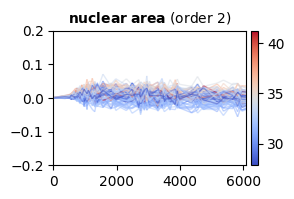

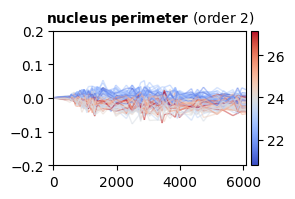

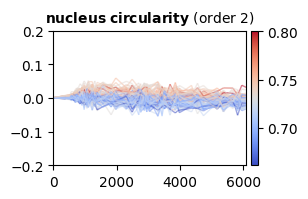

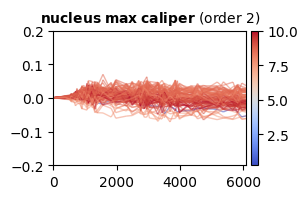

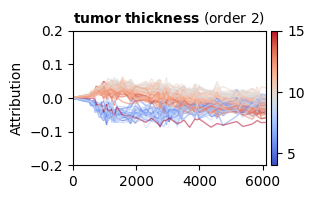

In [78]:
for feature_name in df_plot2_attribution.feature.unique():
    ## different ax.set_ylim
    if feature_name in ['age', 'max_tumor_diameter', 'mitotic_rate', 'nucleus_min_caliper']:
        continue 
    # if feature_name not in ['age', 'max_tumor_diameter', 'mitotic_rate', 'nucleus_min_caliper']:
    #     continue 
    temp = df_plot2_attribution[df_plot2_attribution.feature == feature_name]
    fig, ax = plt.subplots(figsize=(3, 1.75))

    CMAP = "coolwarm"

    for id_val in temp.id.unique():
        line_data = temp[temp.id == id_val].sort_values(by="time")
        x = line_data["time"].values
        y = line_data["value"].values
        c = line_data["color"].values

        # Create line segments with color
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=CMAP, # coolwarm
            norm=plt.Normalize(temp.color.min(), temp.color.max()),
            array=c[:-1],  # color values
            linewidth=1,
            alpha=0.5
        )
        ax.add_collection(lc)

    ax.set_xlim(0, 6100)
    # ax.set_ylim(-0.35, 0.45)
    ax.set_ylim(-0.2, 0.2)
    ax.set_title("$\mathbf{" + str(feature_name).replace("_", "\;") + "}$ (order 2)", fontsize=10)
    if feature_name in ["tumor_thickness", "age"]:
        ax.set_ylabel('Attribution')
        
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
    sm.set_array([])  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    # cbar.set_label("color value")
    # plt.tight_layout()
    plt.savefig(f'results/um_order2_global_{feature_name}.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

In [87]:
palette = {
    "high $\\times$ high": "#b40426",
    "high $\\times$ low": "#fc8d59",
    "low $\\times$ high": "#1b9e77",
    "low $\\times$ low": "#3b4cc0",

    # "other": "#3b4cc0"
    # "other": "#b40426"
}

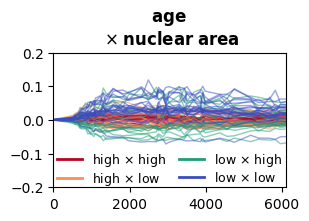

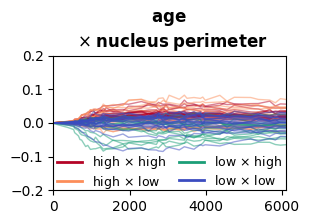

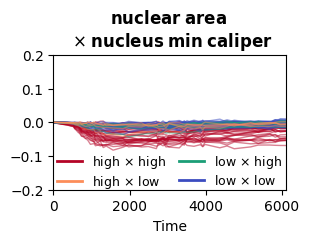

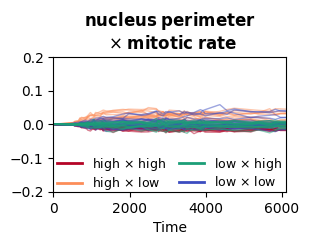

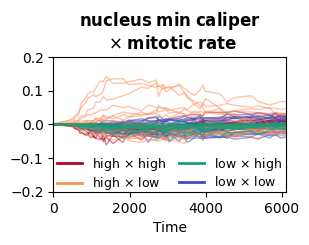

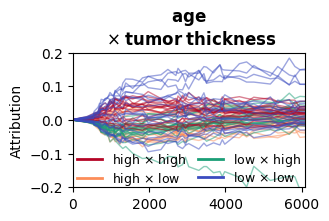

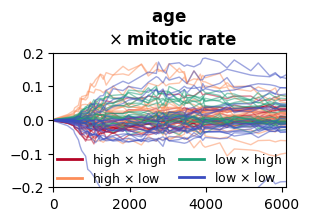

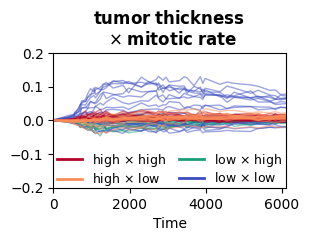

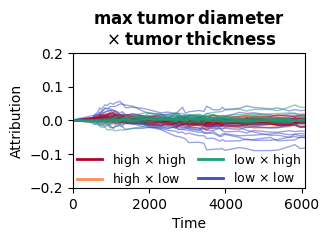

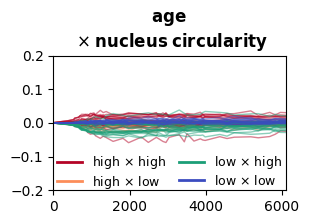

In [91]:
for feature_name in [
    # 'age * largest.basal.tumor.diameter',
    # 'mean.nucleus.min.caliper * age',

    # 'largest.basal.tumor.diameter * mitotic.rate',
    # 'mean.nuclear.area * mean.nucleus.perimeter',

    'mean.nuclear.area * age',
    'mean.nucleus.perimeter * age',
    'mean.nuclear.area * mean.nucleus.min.caliper',
    'mean.nucleus.perimeter * mitotic.rate',
    'mean.nucleus.min.caliper * mitotic.rate',
    'age * tumor.thickness',
    'age * mitotic.rate',
    'tumor.thickness * mitotic.rate',
    'largest.basal.tumor.diameter * tumor.thickness',
    'mean.nucleus.circularity * age'
    ]:
    temp = df_plot2_interaction[df_plot2_interaction.feature == feature_name]

    feat1 = feature_name.split(" * ")[0]
    feat2 = feature_name.split(" * ")[1]
    if feat2 == "age":
        feat2 = feat1
        feat1 = "age"

    high_feat1 = (X_valid.loc[:, feat1].repeat(41) >= X_valid.loc[:, feat1].median()) 
    high_feat2 = (X_valid.loc[:, feat2].repeat(41) >= X_valid.loc[:, feat2].median())
    tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
    tcolor[high_feat1 & high_feat2] = "high $\\times$ high"
    tcolor[high_feat1 & ~high_feat2] = "high $\\times$ low"
    tcolor[~high_feat1 & high_feat2] = "low $\\times$ high"
    tcolor[~high_feat1 & ~high_feat2] = "low $\\times$ low"
    if feature_name == "largest.basal.tumor.diameter * mitotic.rate":
        tcolor[~high_feat1 & ~high_feat2] = "low $\\times$ low"
        tcolor[high_feat1 | high_feat2] = "other"
    if feature_name == "mean.nuclear.area * mean.nucleus.perimeter":
        tcolor[high_feat1 & high_feat2] = "high $\\times$ high"
        tcolor[~(high_feat1 & high_feat2)] = "other"
    temp = temp.assign(color=tcolor)

    fig, ax = plt.subplots(figsize=(3, 1.75))

    for group, group_data in temp.groupby("color", sort=False):
    # for group, group_data in temp.groupby("color"):
        for id_val in group_data.id.unique():
            line_data = group_data[group_data.id == id_val].sort_values("time")
            x = line_data["time"].values
            y = line_data["value"].values
            ax.plot(x, y, color=palette[group], alpha=0.5, linewidth=1)

    ax.set_xlim(0, 6100)
    # ax.set_ylim(-0.35, 0.45)
    ax.set_ylim(-0.2, 0.2)
    ax.set_title("$\mathbf{" + feat_dict[feat1].replace("_", "\;") + "}$ \n $\\times\;\mathbf{" + feat_dict[feat2].replace("_", "\;") + "}$")

    if feature_name in ['age * largest.basal.tumor.diameter', 'largest.basal.tumor.diameter * tumor.thickness']:
        ax.set_xlabel('Time')
        ax.set_ylabel('Attribution')
    if feature_name in ['mean.nucleus.min.caliper * age', 'largest.basal.tumor.diameter * mitotic.rate', 'mean.nuclear.area * mean.nucleus.perimeter',
                        'mean.nuclear.area * mean.nucleus.min.caliper', 'mean.nucleus.min.caliper * mitotic.rate', 'mean.nucleus.perimeter * mitotic.rate',
                        'tumor.thickness * mitotic.rate']:
        ax.set_xlabel('Time')
    if feature_name in ['age * tumor.thickness']:
        ax.set_ylabel('Attribution')

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=label) for label, color in palette.items()]
    ax.legend(
        handles=handles, 
        loc="upper center",
        bbox_to_anchor=(0.5, 0.35), # bottom
        # bbox_to_anchor=(0.505, 1.06),
        # bbox_to_anchor=(0.505, 1),
        ncol=2,  # Spread out horizontally
        frameon=False,
        fontsize=9,
        columnspacing=1,
        labelspacing=0.2
    )

    # Save
    plt.savefig(f'results/um_order2_global_{feat1.replace(".", "-")}_{feat2.replace(".", "-")}_v1.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()